# GUIA 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist


### Ejercicio 1

![image.png](enunciados/ej1.png)

Partiendo de la densidad conjunta $p_{XY}(x, y)$, podemos intentar factorizarla en dos funciones, de forma de que se cumpla que una de ellas solo dependa de x, y la otra dependa de x e y, tal que 


$p_{XY}(x, y) = p_X(x) \cdot p{Y|X}(y|x)$

$ \frac{ e^{ -( 2x + \frac{ y }{ 4x+2 } ) } }{ 2x+1 } \cdot 1 \{ x > 0, y > 0\} = 2 \cdot e^{-2x} \cdot 1 \{ x>0 \} \cdot \frac{1}{4x+2} e^{- \frac{1}{4x+2}y} \cdot 1 \{ y>0 \}$

Se puede ver que

$X \sim \varepsilon(2) $

Y que

$Y|_{X = x} \sim \varepsilon (\frac{1}{4x+2}) $

Entonces, si $T \sim \varepsilon( \lambda )$ entonces $k \cdot T \sim \varepsilon( \frac {\lambda}{k} )$ se puede decir que

$Y = \varepsilon(1) \cdot (4X+2) $


Habiendolo factorizado de este modo, X corresponde como la causa, e Y es el efecto.

### Ejercicio 2

![image.png](enunciados/ej2.png)

In [ ]:
# Cargamos los datos

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


del x_train, y_train, x_test, y_test


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


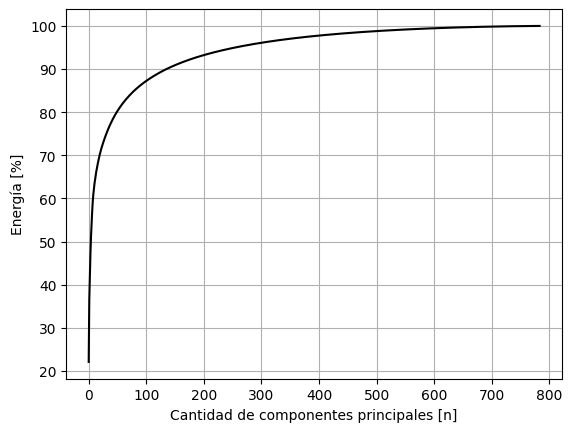

In [13]:
# a)

n_samples_train = x_train.shape[0]
n_samples_test = x_test.shape[0]
X_train = x_train.reshape(n_samples_train, -1)  # Cada imagen es ahora un vector de 784 elementos
X_test = x_test.reshape(n_samples_test, -1)
# Tengo 60000 vectores de 784 elementos (28x28 de c/imagen)

# Calculo la media y la varianza para normalizar
u_train = np.mean(X_train, axis=0)
var_train = np.std(X_train, axis=0)

# Normalizo
X_train_norm = (X_train - u_train)/var_train

# Calculo matriz de covarianza
cov_train = np.cov(X_train_norm.T)

# Calculo AVals, AVecs de la matriz de covarianza
avals, avecs = np.linalg.eig(cov_train)

# Busco los indices que me ordenan los autovalores de mayor a menor
# Igual np.linalg.eig() me parece que los devuelve ordenados de mayor a menor
index_ordenado = np.argsort(avals)[::-1]
avals = avals[index_ordenado]
avecs = avecs[:, index_ordenado]

# Calculo potencias
potencias =  np.cumsum(avals) / np.sum(avals) * 100

# Grafico

plt.figure()
plt.plot(potencias, color = 'k')
plt.xlabel('Cantidad de componentes principales [n]')
plt.ylabel('Energía [%]')
plt.grid(True)
plt.show()


#del n_samples_train, n_samples_test, X_train, X_test, u_train, var_train
#del X_train_norm, cov_train, avals, avecs, index_ordenado, potencias


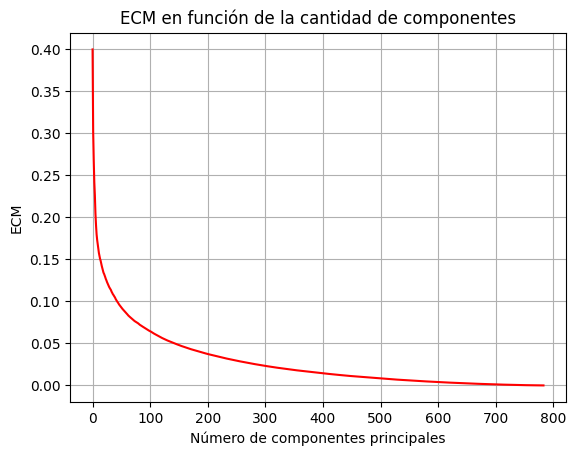

In [ ]:
# b) ECM de testeo vs. Cant de componentes principales

def reconstruccion (x_est_ant, avec_n, x):
    return x_est_ant + np.dot(x, avec_n) * avec_n


X_test_norm = (X_test - u_train) / var_train

ECMs = []

for j in range(n_samples_test):
    X_est_ant = np.zeros_like(X_test_norm[j])
    ECM = []
    for i in range(784):
        X_est = reconstruccion(X_est_ant, avecs[:, i], X_test_norm[j])
        reconst = X_est * var_train + u_train
        ECM.append(np.mean((X_test[j] - reconst)**2))
        X_est_ant = X_est
    ECMs.append(ECM)    

ECM_matrix = np.array(ECMs)


ECM = np.mean(ECM_matrix, axis=0)/X_test.shape[0] # axis=0 promedia todas las filas (10000 imágenes)

plt.figure()
plt.plot(ECM, color = 'k')
plt.xlabel('Número de componentes principales')
plt.ylabel('ECM')
plt.grid(True)
plt.show()


#del X_test_norm, ECMs, i, j, X_est_ant, ECM, X_est, reconst, ECM_matrix


